In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

val_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32)

(5, torch.Size([1, 28, 28]))

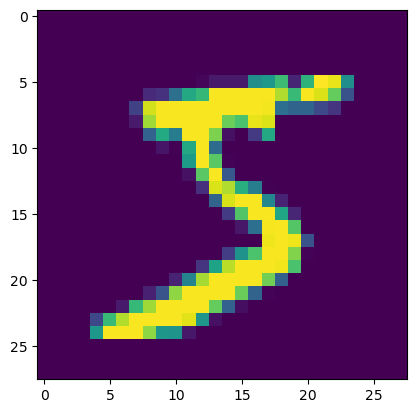

In [3]:
img, label = train_dataset[0]

plt.imshow(img[0])
img_sz = img.shape[-1]
label, img.shape

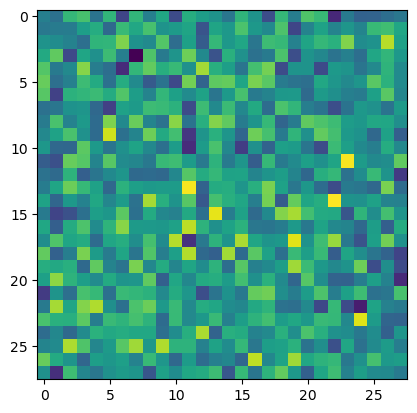

In [4]:
class AEModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(img_sz * img_sz, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            #
            nn.Linear(64, 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            #
            nn.Linear(64, img_sz * img_sz),
        )

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded, encoded


model = AEModel()
model.eval()
img_pred = model(img)[0].view(-1, img_sz, img_sz)
plt.imshow(img_pred[0].detach())

In [5]:
opt = torch.optim.AdamW(model.parameters())
criterion = nn.MSELoss()
avg_train_losses = []
avg_val_losses = []

In [6]:
epochs = 7

accum_steps = 30

try:
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0
        train_bar = tqdm(train_loader, desc="Training")

        opt.zero_grad()
        for i, (x, y) in enumerate(train_bar):
            x = x.squeeze(1)
            y_pred = model(x)[0]

            loss = criterion(y_pred, x.view(-1, img_sz * img_sz))
            avg_train_loss += loss.item()
            (loss / accum_steps).backward()

            if (i + 1) % accum_steps == 0:
                opt.step()
                opt.zero_grad()
                
            train_bar.set_postfix(loss=avg_train_loss / (i + 1))
                

        avg_train_loss /= len(train_loader)

        # Validate
        model.eval()
        avg_val_loss = 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc="Validation"):
                x = x.squeeze(1)
                y_pred = model(x)[0]

                loss = criterion(y_pred, x.view(-1, img_sz * img_sz))
                avg_val_loss += loss.item()

        avg_val_loss /= len(val_loader)

        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)

        print(f"EPOCH {epoch}, Avg Train loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}")

except KeyboardInterrupt:
    print("tired of waiting..")

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 0, Avg Train loss: 0.09811818906267485, Avg Val Loss: 0.0641705804882339


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 1, Avg Train loss: 0.06147346880435944, Avg Val Loss: 0.05819872139503781


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 2, Avg Train loss: 0.058782654176155726, Avg Val Loss: 0.05668938596741841


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 3, Avg Train loss: 0.057872308770815534, Avg Val Loss: 0.056076910203923816


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 4, Avg Train loss: 0.0573114466090997, Avg Val Loss: 0.055689132501618166


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 5, Avg Train loss: 0.056806499423583345, Avg Val Loss: 0.05525335139883593


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 6, Avg Train loss: 0.05640504182974498, Avg Val Loss: 0.054860899183220756


Text(0.5, 1.0, 'train, validation losses')

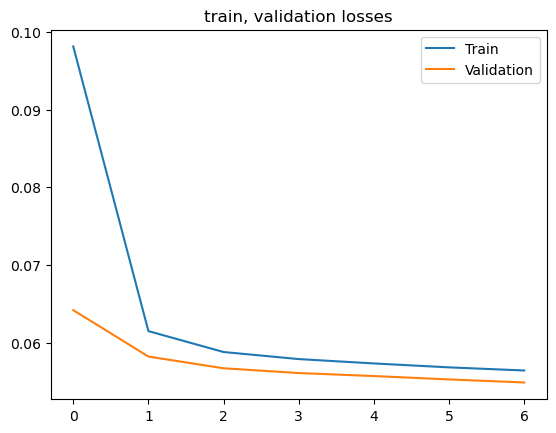

In [8]:
plt.plot(avg_train_losses, label="Train")
plt.plot(avg_val_losses, label="Validation")
plt.legend()
plt.title("train, validation losses")

torch.Size([1, 28, 28])
(1, 28, 28)


Text(0.5, 1.0, 'predicted img')

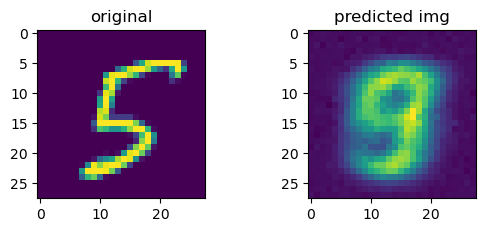

In [12]:
model.eval()
img, _ = val_dataset[23]
img_decoded, z_encoded = model(img)
img_pred = img_decoded.view(-1, img_sz, img_sz).detach().numpy()

print(img.shape)
print(img_pred.shape)

plt.subplot(221)
plt.imshow(img[0].numpy())
plt.title("original")

plt.subplot(222)
plt.imshow(img_pred[0])
plt.title("predicted img")

In [13]:
latent_vectors = [[] for _ in range(10)]

for i in range(1000):
    img, label = val_dataset[i]
    img_pred, latent_vec = model(img)
    
    latent_vectors[label].append(latent_vec[0].detach().numpy())

Text(0.5, 1.0, 'Latent Space')

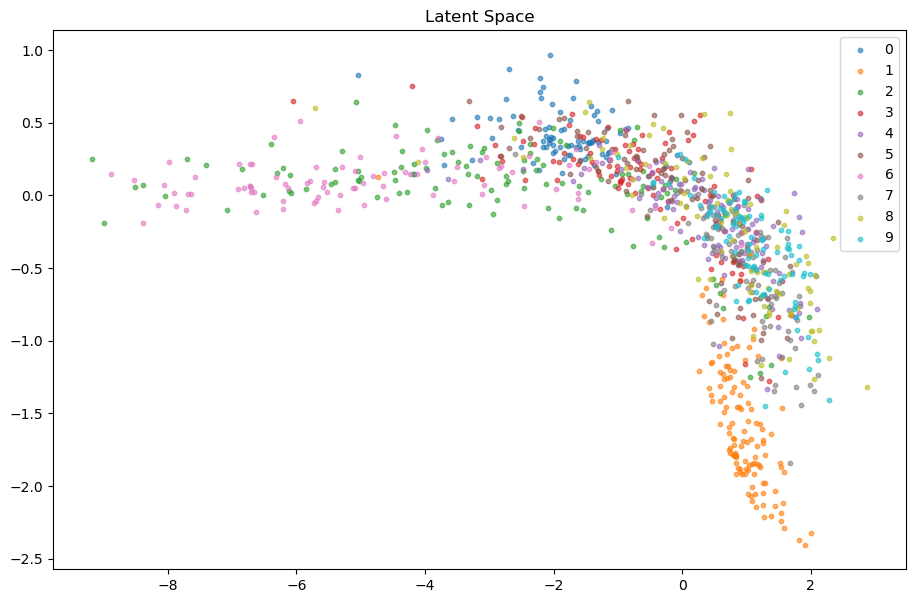

In [14]:
plt.figure(figsize=(11, 7))
for label, points in enumerate(latent_vectors):
    points = np.array(points)
    plt.scatter(x = points[:, 0], y=points[:, 1], label=label, s=10, alpha=0.6)
    

plt.legend()
plt.title("Latent Space")